In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
#import enchant
import stop_words
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer

%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

## RegExp crash course

https://regex101.com

https://regexr.com

In [3]:
match = re.fullmatch(r'\d\d\D\d\d', r'12-12') 
print('YES' if match else 'NO') 

YES


In [4]:
match = re.fullmatch(r'\d\d\D\d\d', r'Т. 12-12') 
print('YES' if match else 'NO') 

NO


In [5]:
print(re.split(r'\W+', 'Где, скажите мне, мои очки??!')) 

['Где', 'скажите', 'мне', 'мои', 'очки', '']


In [6]:
print(re.findall(r'\d\d\.\d\d\.\d{4}', 
                 r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

['21.01.2019', '01.09.2017']


In [7]:
print(re.sub(r'\d\d\.\d\d\.\d{4}', 
             r'DD.MM.YYYY', 
             r'Эта строка написана 21.01.2019, а могла бы и 01.09.2017')) 

Эта строка написана DD.MM.YYYY, а могла бы и DD.MM.YYYY


In [8]:
re.findall(r'\w+$', 'AV is largest Analytics community of India')

['India']

In [9]:
re.findall(r'\w\w', 'AV is largest Analytics community of India')

['AV',
 'is',
 'la',
 'rg',
 'es',
 'An',
 'al',
 'yt',
 'ic',
 'co',
 'mm',
 'un',
 'it',
 'of',
 'In',
 'di']

In [10]:
re.findall(r'@\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail', '@test', '@analyticsvidhya', '@rest']

In [11]:
re.findall(r'@\w+.\w+', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']

In [12]:
re.findall(r'@\w+.(\w+)', 
           'abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz')

['com', 'in', 'com', 'biz']

In [13]:
re.findall(r'[aeiouAEIOU]\w+', 'AV is largest Analytics community of India')

['AV', 'is', 'argest', 'Analytics', 'ommunity', 'of', 'India']

In [14]:
re.findall(r'\d([A-Z][A-Za-z]+)([A-Z][A-Za-z]+)', 
          '1NoahEmma2LiamOlivia3MasonSophia4JacobIsabella5WilliamAva6EthanMia7MichaelEmily')

[('Noah', 'Emma'),
 ('Liam', 'Olivia'),
 ('Mason', 'Sophia'),
 ('Jacob', 'Isabella'),
 ('William', 'Ava'),
 ('Ethan', 'Mia'),
 ('Michael', 'Emily')]

# Обработка реального текста

In [15]:
EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])

In [16]:
GRAMMS = ['NOUN', 'ADJF', 'ADJS', 'PRTF', 'PRTS', 'GRND', 'ADVB']

[**Data**](http://study.mokoron.com/)

---

In [17]:
# -*- coding: utf-8 -*-
import time
import xml.etree.cElementTree as ET
tree = ET.ElementTree(file="file1.xml")
root = tree.getroot()

In [19]:
import csv
our_list=[]
for i in range(200):
    our_list.insert(i, ['data'])
file = open('__data.csv', 'w')
with file:
    ww=csv.writer(file)
    ww.writerows(our_list)
print("Done")

Done


In [20]:
DATA_PATH = '__data.csv'

In [21]:
df = pd.read_csv(DATA_PATH, header=None,
                 names=['ttext'])
print(df.shape)

(200, 1)


In [22]:
df.dtypes

ttext    object
dtype: object

In [23]:
catalog_1=root[0][0]
for i in range(50):
    df.ttext[i]=catalog_1[i].text
catalog_1=root[0][1]
for i in range(50,100):
    df.ttext[i]=catalog_1[i-50].text
catalog_1=root[0][2]
for i in range(100,150):
    df.ttext[i]=catalog_1[i-100].text
catalog_1=root[0][3]
for i in range(150,200):
    df.ttext[i]=catalog_1[i-150].text

In [24]:
df.head(200)

ttext
0    Легенда смешанных единоборств (MMA) Федор Емел...
1    Глава Чечни Рамзан Кадыров прокомментировал по...
2    Британский теннисист Энди Маррей решил покончи...
3    Вратарь испанского «Манллеу» Иван Гонсалес ата...
4    Американский боец смешанного стиля (MMA) Райан...
5    Российская теннисистка Мария Шарапова прокомме...
6    Нападающий сборной России Федор Смолов вспомни...
7    На петербургском курорте «Игора» завершился эт...
8    Автобус упал в пропасть с высоты 130 метров в ...
9    Нападающий сборной России и московского «Локом...
10   Нападающий «Локомотива» и сборной России Федор...
11   plushenkoofficial / Instagram\nДвукратный олим...
12   Канадский боксер Адонис Стивенсон продолжает в...
13   Американский боец смешанного стиля (MMA) Райан...
14   Личные проблемы футболистов интересовали народ...
15   Sport24\nЗащитник «Сибири» Алексей Аравин напа...
16   У российского клуба «Сибирь», выступающего в Ф...
17   Американская теннисистка Серена Уильямс выбила...
18   Российский боец смешанного стиля (MMA) Федор Е...
19   Олимпийская чемпионка Наталья Бестемьянова выс...
20   Французский биатлонист Мартен Фуркад рассказал...
21   Бывший чемпион UFC, белорус Андрей Орловский в...
22   Бывший старший тренер женской сборной России п...
23   Донецкий «Шахтер» попросил больше денег за заи...
24   В ноябре-декабре 2022 года чемпионат мира по ф...
25   Директор Большого Московского цирка Эдгард Зап...
26   Бывший старший тренер женской сборной России В...
27   Сербский теннисист Новак Джокович победил испа...
28   Тренер российского бойца смешанного стиля (ММА...
29   Российская прыгунья в высоту Мария Ласицкене с...
..                                                 ...
170  dailymail.co.uk\nАвиакомпания China Southern A...
171  Поход — это давно уже не только леса центральн...
172  Пятеро жителей Казахстана сдали в багаж в аэро...
173  Бортпроводница из Англии напилась водки на рос...
174  Россиянин, находясь в Таиланде, поехал на арен...
175  Самолеты обанкротившейся авиакомпании «Трансаэ...
176  Ученики ирландской школы St. Brendan's College...
177  @alainbenoit3121 / Twitter\nНа горнолыжном кур...
178  Уходящий год для путешествующих россиян был по...
179  В Китай можно приезжать десятки раз и постоянн...
180  Онлайн-сервис для путешествий Wegoplace опубли...
181  Пассажир круизного лайнера Symphony of the Sea...
182  Объявлено число депортированных из Израиля в 2...
183  Сеть отелей в Японии Henn na, укомплектованная...
184  Стюардесса рассказала о секретных правилах, ко...
185  Аналитическая служба Ассоциации туроператоров ...
186  До насильственного присоединения Эстонии к ССС...
187  Известный российский журналист Игорь Ротарь по...
188  Пассажир самолета, следующего по маршруту Сург...
189  Пассажирка авиакомпании Delta Air Lines пронес...
190  Пассажиры круизного лайнера Norwegian Cruise L...
191  dailymail.co.uk\nПилот самолета попытался забр...
192  Пассажир с серьезным лишним весом заставил стю...
193  Экзотическая черная птица залетела в бизнес-кл...
194  В США в связи с неблагоприятными погодными усл...
195  Европой и Африкой россиян не удивишь. Многие б...
196  Пассажиры авиакомпании TUI вынужденно просидел...
197  Пьяный студент из американского штата Техас вы...
198  Двое туристов из России упали в ущелье 10-метр...
199  Туристы из Америки, забронировавшие на время о...

[200 rows x 1 columns]

In [25]:
df.ttext

0      Легенда смешанных единоборств (MMA) Федор Емел...
1      Глава Чечни Рамзан Кадыров прокомментировал по...
2      Британский теннисист Энди Маррей решил покончи...
3      Вратарь испанского «Манллеу» Иван Гонсалес ата...
4      Американский боец смешанного стиля (MMA) Райан...
5      Российская теннисистка Мария Шарапова прокомме...
6      Нападающий сборной России Федор Смолов вспомни...
7      На петербургском курорте «Игора» завершился эт...
8      Автобус упал в пропасть с высоты 130 метров в ...
9      Нападающий сборной России и московского «Локом...
10     Нападающий «Локомотива» и сборной России Федор...
11     plushenkoofficial / Instagram\nДвукратный олим...
12     Канадский боксер Адонис Стивенсон продолжает в...
13     Американский боец смешанного стиля (MMA) Райан...
14     Личные проблемы футболистов интересовали народ...
15     Sport24\nЗащитник «Сибири» Алексей Аравин напа...
16     У российского клуба «Сибирь», выступающего в Ф...
17     Американская теннисистка

---

In [26]:
corpus, texts = [], []

for message in log_progress(df.ttext.dropna().as_matrix()):
    sp = message.split('\n')
    corpus += sp
    texts += sp
#     break

print(len(corpus), len(texts))

C:\Users\fialk\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


3175 3175


In [27]:
texts

['Легенда смешанных единоборств (MMA) Федор Емельяненко мог в очередной раз в карьере стать чемпионом. Однако финал Гран-при тяжеловесов Bellator пошел совсем не по сценарию россиянина. Как американцу Райану Бэйдеру удалось превзойти Последнего Императора? О главном бое Bellator 214 расскажет «Лента.ру».',
 'На закате Империи',
 'Пускай Последний Император с видимой легкостью разобрался с двумя соперниками по Гран-при, его все равно считали андердогом в противостоянии с Бэйдером. Впечатляющие победы над двумя американскими ветеранами, бывшими бойцами Абсолютного бойцовского чемпионата (UFC) Фрэнком Миром и Чейлом Сонненом оставили больше вопросов, чем ответов.',
 'В какой форме Емельяненко? Насколько уверенно он себя чувствует в вязкой борьбе на канвасе? С Миром Федор разобрался слишком быстро, чтобы делать хоть какие-либо выводы. Да и кто знает, что ждало россиянина, если бы ему не удалось перебить соперника в стойке? Соннен — человек, по сути, из другой весовой категории. Для него уд

In [28]:
corpus

['Легенда смешанных единоборств (MMA) Федор Емельяненко мог в очередной раз в карьере стать чемпионом. Однако финал Гран-при тяжеловесов Bellator пошел совсем не по сценарию россиянина. Как американцу Райану Бэйдеру удалось превзойти Последнего Императора? О главном бое Bellator 214 расскажет «Лента.ру».',
 'На закате Империи',
 'Пускай Последний Император с видимой легкостью разобрался с двумя соперниками по Гран-при, его все равно считали андердогом в противостоянии с Бэйдером. Впечатляющие победы над двумя американскими ветеранами, бывшими бойцами Абсолютного бойцовского чемпионата (UFC) Фрэнком Миром и Чейлом Сонненом оставили больше вопросов, чем ответов.',
 'В какой форме Емельяненко? Насколько уверенно он себя чувствует в вязкой борьбе на канвасе? С Миром Федор разобрался слишком быстро, чтобы делать хоть какие-либо выводы. Да и кто знает, что ждало россиянина, если бы ему не удалось перебить соперника в стойке? Соннен — человек, по сути, из другой весовой категории. Для него уд

**Уберем ссылки:**

In [29]:
corpus = [re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', u'', doc) for doc in corpus]
corpus = [re.sub(' +' , ' ', doc) for doc in corpus]
print(len(corpus))

3175


In [30]:
corpus[1]

'На закате Империи'

**Уберем лишние пробелы:**

In [31]:
corpus = np.asarray([doc.strip().strip('\t').replace('\n', u'') for doc in corpus])
print(len(corpus))

3175


In [32]:
corpus[1]

'На закате Империи'

**Уберем другие лишние символы:**

In [33]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
regex_punct = re.compile('[%s]' % re.escape(string.punctuation))
regex_dig = re.compile('[%s]' % re.escape(string.digits))
regex_symb = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
regex_struct = re.compile('[%s]' % string.printable + string.whitespace)
emoji_pattern = re.compile("["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+")

In [35]:
corpus = [regex_punct.sub('', doc) for doc in corpus]
print(len(corpus))

3175


In [36]:
corpus[0]

'Легенда смешанных единоборств MMA Федор Емельяненко мог в очередной раз в карьере стать чемпионом Однако финал Гранпри тяжеловесов Bellator пошел совсем не по сценарию россиянина Как американцу Райану Бэйдеру удалось превзойти Последнего Императора О главном бое Bellator 214 расскажет «Лентару»'

In [37]:
corpus = [regex_dig.sub('', doc) for doc in corpus]
print(len(corpus))

3175


In [38]:
corpus[0]

'Легенда смешанных единоборств MMA Федор Емельяненко мог в очередной раз в карьере стать чемпионом Однако финал Гранпри тяжеловесов Bellator пошел совсем не по сценарию россиянина Как американцу Райану Бэйдеру удалось превзойти Последнего Императора О главном бое Bellator  расскажет «Лентару»'

In [39]:
corpus = [regex_symb.sub(' ', doc) for doc in corpus]
print(len(corpus))

3175


In [40]:
corpus[0]

'Легенда смешанных единоборств MMA Федор Емельяненко мог в очередной раз в карьере стать чемпионом Однако финал Гранпри тяжеловесов Bellator пошел совсем не по сценарию россиянина Как американцу Райану Бэйдеру удалось превзойти Последнего Императора О главном бое Bellator  расскажет  Лентару '

In [41]:
corpus = [regex_struct.sub('', doc) for doc in corpus]
print(len(corpus))

3175


In [42]:
corpus[0]

'Легенда смешанных единоборств MMA Федор Емельяненко мог в очередной раз в карьере стать чемпионом Однако финал Гранпри тяжеловесов Bellator пошел совсем не по сценарию россиянина Как американцу Райану Бэйдеру удалось превзойти Последнего Императора О главном бое Bellator  расскажет  Лентару '

In [43]:
corpus = [re.sub(' +' , ' ', doc.strip()) for doc in corpus]
print(len(corpus))

3175


In [44]:
corpus[0]

'Легенда смешанных единоборств MMA Федор Емельяненко мог в очередной раз в карьере стать чемпионом Однако финал Гранпри тяжеловесов Bellator пошел совсем не по сценарию россиянина Как американцу Райану Бэйдеру удалось превзойти Последнего Императора О главном бое Bellator расскажет Лентару'

In [45]:
corpus[0]

'Легенда смешанных единоборств MMA Федор Емельяненко мог в очередной раз в карьере стать чемпионом Однако финал Гранпри тяжеловесов Bellator пошел совсем не по сценарию россиянина Как американцу Райану Бэйдеру удалось превзойти Последнего Императора О главном бое Bellator расскажет Лентару'

In [46]:
texts = np.asarray([txt for doc, txt in zip(corpus, texts) if len(doc) > 0])
print(len(texts))
corpus = np.asarray([doc for doc in corpus if len(doc) > 0])
print(len(corpus))

2962
2962


In [47]:
corpus = [doc.lower() for doc in corpus]
print(len(corpus))

2962


In [48]:
corpus[500]

'он вырос на боях емельяненко но теперь готов отправить кумира на пенсию'

In [49]:
corpus = [emoji_pattern.sub('', doc) for doc in corpus]
print(len(corpus))

2962


In [50]:
corpus[100]

'больше важных новостей в telegramканале лента дня подписывайтесь'

In [51]:
morph = pymorphy2.MorphAnalyzer()

In [52]:
corpus_tokens = []
inds_to_drop = []

for i, sentence in enumerate(log_progress(corpus[:])):
    tmp_tokens = []
    sp = sentence.split()
    for word in sp:
        if word not in stop_words.get_stop_words('ru'):
            if morph.word_is_known(word):
                tmp_tokens.append(word)
    if len(tmp_tokens) > 0:
        corpus_tokens.append(tmp_tokens)
    else:
        inds_to_drop.append(i)
#     break
        
print(len(corpus_tokens), len(texts))

2813 2962


In [53]:
print(len(texts))
texts = [t for i, t in enumerate(texts) if i not in inds_to_drop]
print(len(texts))

2962
2813


In [54]:
stemmer = RussianStemmer()

*см. также  **лемамтизацию** в [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/guide.html#normalization) и [nltk](https://www.nltk.org/api/nltk.stem.html?highlight=lemmatizer#nltk.stem.wordnet.WordNetLemmatizer)*

In [55]:
corpus_tokens_stem = []

for i, tokens in enumerate(log_progress(corpus_tokens[:])):
    tmp = [stemmer.stem(word) for word in tokens]
    corpus_tokens_stem.append(tmp)
#     break
    
print(len(corpus_tokens_stem))

2813


In [56]:
corpus_tokens[100]

['важных', 'новостей', 'лента', 'дня', 'подписывайтесь']

In [57]:
corpus_tokens_stem[100]

['важн', 'новост', 'лент', 'дня', 'подписыва']

---

In [58]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

2813 2813


In [59]:
print(texts)

['Легенда смешанных единоборств (MMA) Федор Емельяненко мог в очередной раз в карьере стать чемпионом. Однако финал Гран-при тяжеловесов Bellator пошел совсем не по сценарию россиянина. Как американцу Райану Бэйдеру удалось превзойти Последнего Императора? О главном бое Bellator 214 расскажет «Лента.ру».'
 'На закате Империи'
 'Пускай Последний Император с видимой легкостью разобрался с двумя соперниками по Гран-при, его все равно считали андердогом в противостоянии с Бэйдером. Впечатляющие победы над двумя американскими ветеранами, бывшими бойцами Абсолютного бойцовского чемпионата (UFC) Фрэнком Миром и Чейлом Сонненом оставили больше вопросов, чем ответов.'
 ... 'Обратная связь с отделом «Путешествия»:'
 'Если вы стали свидетелем важного события, у вас есть новость или идея для материала, напишите на этот адрес: travel@lenta-co.ru'
 'Больше важных новостей в Telegram-канале «Лента дня». Подписывайтесь!']


In [60]:
print(corpus_tokens_stem)

[list(['легенд', 'смеша', 'единоборств', 'федор', 'емельяненк', 'очередн', 'карьер', 'стат', 'чемпион', 'фина', 'тяжеловес', 'пошел', 'сценар', 'россиянин', 'американц', 'уда', 'превзойт', 'последн', 'император', 'главн', 'бо', 'расскажет'])
 list(['закат', 'импер'])
 list(['пуска', 'последн', 'император', 'видим', 'легкост', 'разобра', 'двум', 'соперник', 'равн', 'счита', 'противостоян', 'впечатля', 'побед', 'двум', 'американск', 'ветеран', 'бывш', 'бойц', 'абсолютн', 'бойцовск', 'чемпионат', 'фрэнк', 'мир', 'остав', 'вопрос', 'ответ'])
 ... list(['обратн', 'связ', 'отдел', 'путешеств'])
 list(['стал', 'свидетел', 'важн', 'событ', 'новост', 'иде', 'материа', 'напиш', 'адрес'])
 list(['важн', 'новост', 'лент', 'дня', 'подписыва'])]


In [61]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

2813


In [62]:
print(diffs)

[22  2 26 ...  4  9  5]


(0, 30)

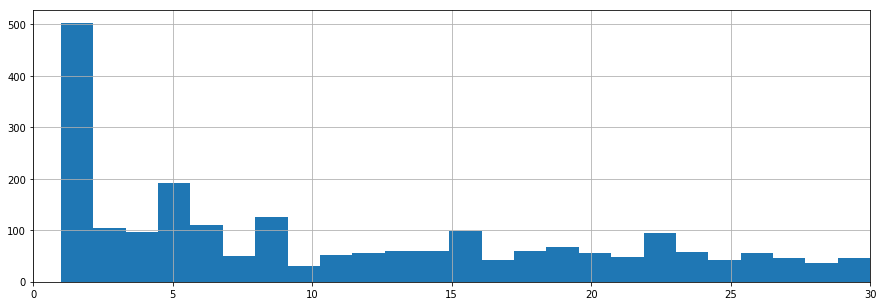

In [63]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 30)

In [64]:
corpus_tokens_stem[diffs == 5]

array([list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['трагед', 'произошл', 'переезд', 'город', 'тарих']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['титов', 'явля', 'учениц', 'академ', 'плющенк']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['важн', 'новост', 'лент', 'дня', 'подписыва']),
       list(['фот', 'григор', 'сысо', 'ри', 'новост']),
       list(['б', 'прос', 'прощен', 'кляст', 'любв']),
       list(['фот', 'григор', 'сысо', 'ри', 'новост']),
       list(['матч', 'заверш', 'п

In [65]:
np.unique(corpus_tokens_stem).shape[0] / float(corpus_tokens_stem.shape[0])

0.8027017419125488

In [66]:
stat = {}

tmp_corp, tmp_texts = [], []

for i, tokens in enumerate(log_progress(corpus_tokens_stem)):
    s = ' '.join(tokens)
    if stat.get(s, None) is None:
        stat[s] = True
        tmp_corp.append(tokens)
        tmp_texts.append(texts[i])
        
corpus_tokens_stem = tmp_corp
texts = tmp_texts
print(len(corpus_tokens_stem), len(texts))

2258 2258


In [67]:
print(texts)

['Легенда смешанных единоборств (MMA) Федор Емельяненко мог в очередной раз в карьере стать чемпионом. Однако финал Гран-при тяжеловесов Bellator пошел совсем не по сценарию россиянина. Как американцу Райану Бэйдеру удалось превзойти Последнего Императора? О главном бое Bellator 214 расскажет «Лента.ру».', 'На закате Империи', 'Пускай Последний Император с видимой легкостью разобрался с двумя соперниками по Гран-при, его все равно считали андердогом в противостоянии с Бэйдером. Впечатляющие победы над двумя американскими ветеранами, бывшими бойцами Абсолютного бойцовского чемпионата (UFC) Фрэнком Миром и Чейлом Сонненом оставили больше вопросов, чем ответов.', 'В какой форме Емельяненко? Насколько уверенно он себя чувствует в вязкой борьбе на канвасе? С Миром Федор разобрался слишком быстро, чтобы делать хоть какие-либо выводы. Да и кто знает, что ждало россиянина, если бы ему не удалось перебить соперника в стойке? Соннен — человек, по сути, из другой весовой категории. Для него удары

In [68]:
print(corpus_tokens_stem)

[['легенд', 'смеша', 'единоборств', 'федор', 'емельяненк', 'очередн', 'карьер', 'стат', 'чемпион', 'фина', 'тяжеловес', 'пошел', 'сценар', 'россиянин', 'американц', 'уда', 'превзойт', 'последн', 'император', 'главн', 'бо', 'расскажет'], ['закат', 'импер'], ['пуска', 'последн', 'император', 'видим', 'легкост', 'разобра', 'двум', 'соперник', 'равн', 'счита', 'противостоян', 'впечатля', 'побед', 'двум', 'американск', 'ветеран', 'бывш', 'бойц', 'абсолютн', 'бойцовск', 'чемпионат', 'фрэнк', 'мир', 'остав', 'вопрос', 'ответ'], ['форм', 'емельяненк', 'наскольк', 'уверен', 'чувств', 'вязк', 'борьб', 'мир', 'федор', 'разобра', 'быстр', 'дела', 'вывод', 'знает', 'ждал', 'россиянин', 'уда', 'переб', 'соперник', 'стойк', 'сут', 'весов', 'категор', 'удар', 'емельяненк', 'поцелу', 'восточн', 'экспресс', 'американск', 'гангстер', 'неплох', 'выглядел', 'федор', 'борьб', 'насторож', 'насторож', 'поклонник', 'российск', 'легенд', 'преддвер', 'поединк', 'опасн'], ['бо', 'малогабаритн', 'федор', 'подчеркн

In [69]:
corpus_tokens_stem = np.asarray(corpus_tokens_stem)
texts = np.asarray(texts)

print(len(corpus_tokens_stem), len(texts))

2258 2258


In [70]:
print(texts)

['Легенда смешанных единоборств (MMA) Федор Емельяненко мог в очередной раз в карьере стать чемпионом. Однако финал Гран-при тяжеловесов Bellator пошел совсем не по сценарию россиянина. Как американцу Райану Бэйдеру удалось превзойти Последнего Императора? О главном бое Bellator 214 расскажет «Лента.ру».'
 'На закате Империи'
 'Пускай Последний Император с видимой легкостью разобрался с двумя соперниками по Гран-при, его все равно считали андердогом в противостоянии с Бэйдером. Впечатляющие победы над двумя американскими ветеранами, бывшими бойцами Абсолютного бойцовского чемпионата (UFC) Фрэнком Миром и Чейлом Сонненом оставили больше вопросов, чем ответов.'
 ...
 'По словам профессора, в объявлении было упоминание о том, что вход в дом оснащен камерами, однако на самом деле они висели не при входе. «Я был удивлен и немедленно отключил их. Не думаю, что мы занимались чем-то странным, пока камеры были включены, но мой двухлетний ребенок ходил перед ними голышом», — посетовал Бигхэм.'
 

In [71]:
print(corpus_tokens_stem)

[list(['легенд', 'смеша', 'единоборств', 'федор', 'емельяненк', 'очередн', 'карьер', 'стат', 'чемпион', 'фина', 'тяжеловес', 'пошел', 'сценар', 'россиянин', 'американц', 'уда', 'превзойт', 'последн', 'император', 'главн', 'бо', 'расскажет'])
 list(['закат', 'импер'])
 list(['пуска', 'последн', 'император', 'видим', 'легкост', 'разобра', 'двум', 'соперник', 'равн', 'счита', 'противостоян', 'впечатля', 'побед', 'двум', 'американск', 'ветеран', 'бывш', 'бойц', 'абсолютн', 'бойцовск', 'чемпионат', 'фрэнк', 'мир', 'остав', 'вопрос', 'ответ'])
 ...
 list(['слов', 'профессор', 'объявлен', 'упоминан', 'вход', 'дом', 'оснащ', 'камер', 'дел', 'висел', 'вход', 'удивл', 'немедлен', 'отключ', 'дума', 'занима', 'стран', 'камер', 'включ', 'ребенок', 'ход', 'голыш', 'посетова'])
 list(['добав', 'жалоб', 'владелец', 'квартир', 'ответ', 'груб', 'сообщен', 'остав', 'постояльц', 'негативн', 'отз', 'сайт'])
 list(['сентябр', 'турист', 'шотланд', 'нашл', 'скрыт', 'камер', 'квартир', 'котор', 'снял', 'отпуск

In [72]:
diffs = np.asarray([len(tokens) for tokens in corpus_tokens_stem])
print(len(diffs))

2258


In [73]:
print(diffs)

[22  2 26 ... 23 12 25]


(0, 10)

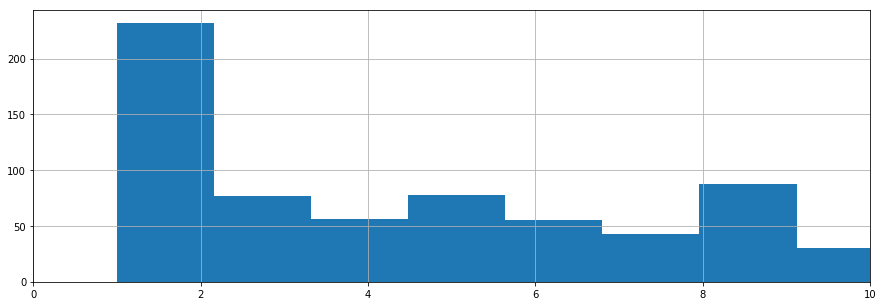

In [74]:
plt.figure(figsize=(15, 5))
plt.hist(diffs, bins=100)
plt.grid(True)
plt.xlim(0, 10)

In [75]:
corpus_tokens_stem[diffs == 7]

array([list(['вырос', 'бо', 'емельяненк', 'гот', 'отправ', 'кумир', 'пенс']),
       list(['сет', 'высмея', 'выступлен', 'дет', 'рамза', 'кадыров', 'ринг']),
       list(['будущ', 'хабиб', 'закат', 'уход', 'шарапов', 'ждет', 'спорт']),
       list(['росс', 'проигра', 'хорват', 'пенальт', 'команд', 'ник', 'стыдн']),
       list(['смол', 'провал', 'оста', 'росс', 'ждал', 'англ', 'герман']),
       list(['мамаев', 'кокорин', 'отправ', 'прос', 'прощен', 'готов', 'плат']),
       list(['сво', 'высказыван', 'вызва', 'волн', 'недовольств', 'частност', 'глав']),
       list(['загитов', 'медведев', 'встрет', 'одн', 'катк', 'об', 'проигра']),
       list(['защит', 'загитов', 'титул', 'главн', 'интриг', 'чемпионат', 'европ']),
       list(['поддержива', 'контакт', 'участник', 'кругл', 'стол', 'сторон', 'власт']),
       list(['посадк', 'рэпер', 'запрет', 'фильм', 'изнасилован', 'главн', 'скандал']),
       list(['жига', 'подня', 'встреч', 'пробл', 'стат', 'относ', 'росс']),
       list(['обвин', 

In [76]:
corpus_tokens_stem[diffs >= 8].shape

(1717,)

In [77]:
corp4learning = corpus_tokens_stem[diffs >= 8]
texts4learning = texts[diffs >= 8]

In [78]:
tmp_corp = []

for tokens in corp4learning:
    tmp_corp.append([t for t in tokens if len(t) > 2])
corp4learning = tmp_corp

In [79]:
vocab = np.unique(np.concatenate(corp4learning).flatten()).tolist()
print(len(vocab))

10383


In [80]:
print(vocab)

['аарон', 'абонент', 'абориген', 'аборт', 'абрам', 'абсолютист', 'абсолютн', 'абстрактн', 'абсурд', 'абхаз', 'авангардн', 'авантюр', 'авантюризм', 'авар', 'аватар', 'август', 'авдот', 'авен', 'авиабилет', 'авиадиспетчерск', 'авиакомпан', 'авиалайнер', 'авиарейс', 'авиасообщен', 'авиацион', 'аврор', 'австрал', 'австралийк', 'австралийск', 'австралийц', 'австриец', 'австрийск', 'австрийц', 'автобиограф', 'автобиографическ', 'автобус', 'автогонк', 'автодром', 'автокефал', 'автоматизирова', 'автомобил', 'автомобильн', 'автоном', 'автопилот', 'автор', 'авторитетн', 'авторск', 'автосалон', 'автостоп', 'агат', 'агент', 'агентств', 'агитк', 'аграрн', 'агресс', 'агрессивн', 'агрессор', 'адам', 'адаптир', 'адаптирова', 'адвокат', 'адекватн', 'адлер', 'административн', 'администратор', 'администрац', 'адонис', 'адреналин', 'адрес', 'адресова', 'азар', 'азарт', 'азербайджа', 'азиатск', 'аист', 'айз', 'айсберг', 'академ', 'акац', 'акбар', 'акведук', 'акир', 'аккаунт', 'аккредитац', 'аккуратн', 'акс

In [81]:
print(vocab[774])

вдых


In [82]:
tree1 = ET.ElementTree(file="laba2_file.xml")
root1 = tree1.getroot()

In [83]:
catalogs=root1[0][0]

print(catalogs[49].text)

российск фигуристк алин загитов прокомментирова выступлен чемпионат европ минск слов переда тасс заня мест тройк призер стал могл оста рад серебрян меда хотел выступ призна летн фигуристк январ фигуристк выступа произвольн программ старт соревнован загитов лидирова общ зачет турнир сумел сохран преимуществ итог произвольн коротк программ сильн стал россиянк соф загитов завоева серебр прошедш саранск чемпионат росс загитов заня пят мест несмотр подобн результат равн получ мест сборн росс триумфатор национальн первенств имел прав выступа чемпионат европ сил возраст загитов олимпийск чемпионк выигрыва чемпионат европ важн новост лент дня подписыва


In [84]:
import csv
our_list=[]
for i in range(200):
    our_list.insert(i, ['data'])
file = open('catalogs.csv', 'w')
with file:
    ww=csv.writer(file)
    ww.writerows(our_list)
print("Done")

Done


In [162]:
DATA = 'catalogs.csv'

In [163]:
df1 = pd.read_csv(DATA, header=None,
                 names=['text'])
print(df1.shape)

(200, 1)


In [164]:
df1.dtypes

text    object
dtype: object

In [165]:
catalogs=root1[0][0]
for i in range(50):
    df1.text[i]=catalogs[i].text

In [176]:
texts1=[]
for i in range(0,200):
    sp1 = df1.text[i].split()
    texts1.insert(i,sp1)
print(texts1[0])

['легенд', 'смеша', 'единоборств', 'федор', 'емельяненк', 'очередн', 'карьер', 'стат', 'чемпион', 'фина', 'тяжеловес', 'пошел', 'сценар', 'россиянин', 'американц', 'уда', 'превзойт', 'последн', 'император', 'главн', 'бо', 'расскажет', 'закат', 'импер', 'пуска', 'последн', 'император', 'видим', 'легкост', 'разобра', 'двум', 'соперник', 'равн', 'счита', 'противостоян', 'впечатля', 'побед', 'двум', 'американск', 'ветеран', 'бывш', 'бойц', 'абсолютн', 'бойцовск', 'чемпионат', 'фрэнк', 'мир', 'остав', 'вопрос', 'ответ', 'форм', 'емельяненк', 'наскольк', 'уверен', 'чувств', 'вязк', 'борьб', 'мир', 'федор', 'разобра', 'быстр', 'дела', 'вывод', 'знает', 'ждал', 'россиянин', 'уда', 'переб', 'соперник', 'стойк', 'сут', 'весов', 'категор', 'удар', 'емельяненк', 'поцелу', 'восточн', 'экспресс', 'американск', 'гангстер', 'неплох', 'выглядел', 'федор', 'борьб', 'насторож', 'насторож', 'поклонник', 'российск', 'легенд', 'преддвер', 'поединк', 'опасн', 'бо', 'малогабаритн', 'федор', 'подчеркнут', 'изб

In [167]:
texts1[0][0]

'ман'

In [127]:
dig=[]
for i in range(50):
    dig.insert(i,len(texts1[i]))
print(len(dig))

50


In [129]:
for i in range(50):
    for k in range (dig[i]):
        for j in range(10383):
            if texts1[i][k]==vocab[j]:
                texts1[i][k]=j
                print(j)

3910
7421
5394
7488
1110
5918
9744
4941
385
2259
6870
4200
3926
6053
573
10348
7706
1816
5128
6331
1615
4558
4772
2168
5105
768
6484
10153
1570
9582
6053
3822
10175
9074
2499
8839
5391
7673
3422
319
131
3038
4632
2368
3510
8839
8129
5128
7969
2168
9929
5128
2854
2260
4099
1661
3497
2239
4375
6276
3847
8839
9574
1244
2240
2486
2901
8619
8958
8186
2517
2915
7122
1733
3008
6829
3847
9375
2664
10102
8043
573
1724
6561
9292
3982
6710
8134
6829
1615
4558
9786
477
852
4062
6022
5391
9357
4099
8128
1539
1615
4056
5928
6319
2690
131
4534
4798
4550
1615
8512
10183
7152
5691
2126
1615
2933
5094
2282
131
9996
9445
2272
4978
9188
8814
3118
2934
131
4200
7969
1615
8814
5816
1639
6359
2354
2854
8968
1350
5057
7935
3510
9915
7018
135
5523
573
10348
4534
9744
332
1460
3293
4535
1537
1517
8859
8785
2763
5749
5816
4557
1615
10183
4772
5457
5593
1794
7892
6293
7491
4056
5816
8043
9800
3926
1444
221
192
4522
3217
1520
9468
3220
2844
6179
4880
7362
1327
8010
6669
5212
869
8334
5078
10352
4915
7856
9338
3161

8910
5247
3036
1570
8764
6502
9292
490
8614
278
9200
205
9512
7062
2265
4932
7970
9300
2540
9989
8116
8839
5903
2455
134
4146
2776
1085
6630
5247
5180
8043
6502
4437
7974
148
5975
5542
8839
205
8048
6055
6998
5247
9543
6428
9293
903
7971
2126
7891
1115
1039
4095
5611
10266
903
3619
708
470
9290
5542
4864
8839
6986
10027
573
5192
5247
2282
4820
1635
533
4990
204
3510
207
7433
2141
6805
8800
7622
5768
1960
7433
5221
5211
6043
5204
6854
2120
1176
9481
4236
1727
3008
2693
7241
7586
10302
5251
5204
8043
8953
2282
5984
1642
432
6450
2879
2033
2866
7435
5248
4534
3513
1615
1507
8217
207
6043
2866
5209
10332
5218
8839
4270
7745
4343
1537
1615
7150
1005
292
6186
3406
9213
4247
7196
5114
5504
5395
5247
8177
3754
4038
9588
6385
1612
5997
7747
6043
3182
1759
1398
1011
713
205
4343
8929
7999
7835
7014
4428
6651
2003
1004
9602
10188
2866
5210
206
2103
490
9264
3252
320
3297
5992
4976
9560
660
3523
2660
5395
573
9992
8839
5259
386
2702
3060
7433
6058
2576
3467
5898
8203
8177
2001
2440
443
2226
8516
2

8160
1502
1237
995
10007
5430
1130
3308
2577
5463
4141
3851
5170
8807
8811
6115
4099
6014
7424
1182
7759
2705
4857
5997
9969
8142
7460
17
9800
7003
6855
4438
1537
8251
5698
8831
5501
6193
2689
3626
4145
2652
5724
6109
5837
2705
8724
6931
990
9782
5206
3160
10218
358
8814
8468
8434
995
8495
8116
4733
9581
6868
1941
7196
7435
9125
7166
5768
1961
4814
9292
2033
2856
6022
8497
7173
421
8199
1737
4033
5677
9647
9812
5094
4846
8481
1816
3182
2854
5402
3080
7912
7121
8043
7336
10004
852
1727
6565
4033
3497
5548
6276
694
7441
1583
9032
9214
3834
9342
9439
9591
8457
6587
7466
5685
1855
10124
4545
4157
6709
1566
2141
7491
9357
1088
9269
1817
6977
5698
5094
8710
9991
4057
3925
8530
6413
8129
782
4458
1257
3650
6469
5813
2945
8995
1424
6717
4864
2451
4435
2451
4384
2451
7393
5655
2451
2950
2945
8154
4755
8710
3732
5637
1468
6297
2878
1288
10025
6042
6479
1311
1344
8816
1330
9991
8796
1440
695
1773
5388
3763
6685
4237
3007
9963
8767
5701
4048
9800
8612
1152
8483
6563
4237
6430
5701
4048
5653
8709
6

4119
8839
2282
3232
5206
6972
1440
7873
3205
6890
2879
7479
4063
1675
9992
5408
938
8590
2173
7488
9292
9992
3584
9293
3370
2543
5408
1855
6710
1215
3206
5206
9374
626
3218
8002
9455
4158
4706
204
3947
2282
9790
4615
9290
7873
8170
3205
5204
7507
6972
4035
2879
6852
7130
4253
8839
5572
6710
3205
9948
5390
1151
4557
2900
5408
3315
285
2168
5181
443
9291
2126
7010
3205
4535
1811
5406
5068
7268
2001
10151
845
8369
4035
7485
8249
679
8581
8545
10377
6109
4095
5892
3753
10187
845
4184
681
5760
6552
8106
9223
7104
9800
148
5975
5768
4903
7140
5666
421
4184
8386
7949
1071
7513
6912
8284
7698
3753
6856
1269
6251
2276
9325
4907
679
5389
8349
2815
4184
819
421
4907
1007
6651
9659
3060
9890
5837
3092
1004
3839
1270
8546
9213
2744
768
6043
4903
5068
4557
3065
2070
9113
5264
7514
2326
6202
1668
5372
7533
7329
3643
6299
6784
8237
6719
7969
9378
1778
8237
4688
3001
4033
4435
2118
1615
5742
809
7439
8341
533
2988
1815
5742
5204
9133
3634
1842
4299
9292
4732
2010
7201
8002
1260
4016
7878
8002
7888
2048

8580
3572
3080
8814
2232
8439
9556
5262
9292
4000
5079
5389
4447
1652
1064
8264
542
1807
9453
4730
8827
8025
286
8839
7432
5362
4223
6651
372
2168
9292
8764
2255
4797
4739
54
8832
2282
8839
5477
8832
9292
9800
9285
265
9292
2168
6647
698
6502
7296
1149
3931
3464
4582
9334
9295
8290
7909
5360
6314
4440
1811
10257
3931
4950
7442
1743
5865
1610
6220
4891
3551
8264
2861
8498
2981
9785
5389
5262
2254
8839
4686
4472
9295
7969
8839
7972
9505
964
4747
2988
6099
5524
393
3633
3018
1767
7971
7589
8311
9301
2609
4184
9388
1578
4886
5478
3634
1615
4291
992
9577
3420
7971
9455
3633
9301
2176
264
2171
9292
4253
8839
8170
285
10332
6616
2254
2861
8043
8852
8043
4610
8474
403
8958
1014
3420
4768
8839
8138
5041
7591
1635
5383
4524
9293
8209
8591
8668
3841
8384
1203
10355
1064
6710
8339
7441
4540
631
470
5406
9120
5406
5734
1671
175
4437
4278
573
6502
8606
20
7432
8053
5728
2999
8250
1081
8557
8920
62
2105
8477
6547
7832
1865
4000
294
3878
5728
10062
10222
6286
4575
2497
2999
8193
62
595
7116
8456
7832


9589
7107
8984
6977
4259
6470
3422
2081
1046
888
8951
3787
5180
8043
1393
5198
6155
2132
1697
1751
8249
7250
9644
3938
3422
3958
9074
1811
3144
1615
532
4614
1961
9962
6899
5198
5180
8043
5768
2835
1039
4476
888
5475
6190
9642
1697
1284
5057
4522
2032
4095
10224
4094
1648
6793
1039
8043
9400
5057
7435
6717
8249
1003
9315
3736
8369
7379
3182
4702
9743
1599
8384
9400
853
4440
8375
9641
7435
7705
1531
1392
9187
9225
4048
9556
4184
5783
4488
8597
3497
9315
6149
5276
4170
5420
1697
573
9992
7435
828
9187
5782
7379
5180
5899
582
2466
5675
7991
9318
4880
8250
845
4048
1537
9187
9225
4287
5597
2141
2006
9948
4439
2389
1093
1085
2300
973
5597
7116
5309
3513
4024
2141
2110
9948
5386
5597
5309
2749
8769
8847
7127
4641
5824
9400
6473
8128
5311
3053
5307
7991
8043
9748
5596
2007
3422
6830
4475
9758
2897
7319
853
7104
9004
8375
7435
3052
4259
6344
8839
9349
815
8984
3144
6336
9004
10083
1915
5389
4301
2148
1615
1734
6425
6977
8678
9494
651
4173
4359
3016
6702
8841
2900
1615
6397
3409
5546
9293
7637


8863
6617
5094
8376
3182
8175
8614
3182
8795
1093
9533
8863
4914
5538
8710
8602
1166
230
9269
4518
6866
6873
5115
4440
7486
4036
7433
8795
2967
2065
3697
7632
3304
10055
699
2079
6699
5623
3098
791
10130
7435
2103
8795
10163
768
3840
8795
4557
5997
5626
7516
9800
8795
9017
8043
1537
7107
9344
9491
7702
791
3217
8795
8043
1950
3224
4099
8868
6100
8604
4078
5447
7478
2485
995
8795
6515
3524
8795
4033
7686
1008
8379
2993
5970
1004
4768
513
1839
9355
5976
3165
649
8010
4368
5180
9669
8710
10356
9859
1009
8242
1855
8011
4323
6328
8010
8163
7809
8826
7504
5755
8283
6058
1961
7140
8825
8834
8545
6109
2814
10056
1586
4551
574
8384
9377
10267
3495
5232
1615
4150
7549
2033
7340
8832
9468
4121
10240
1016
122
9801
6341
9800
2033
7210
5094
573
9992
5756
2268
1867
3273
1070
2243
9283
4772
10352
4556
5232
8725
3161
8825
3215
2065
8727
7986
4048
9962
1615
4660
1874
508
5221
3218
6973
1839
3588
3982
2281
7289
6425
5398
7937
3619
8471
3161
6710
5381
3944
3218
9200
2268
7933
7937
3161
5805
6353
6353
2033

3847
8384
7038
6111
3013
429
8471
9579
715
4876
3722
1961
6210
8229
5478
10369
9447
5381
5542
6403
162
3388
5972
7107
8753
9992
6408
2066
5077
4143
3971
1537
7107
4350
7928
5204
4783
6401
6615
4139
5442
7319
1093
4886
7038
9910
1629
3327
4490
7301
6088
3013
8817
7801
973
7928
1211
9201
5500
719
9340
4898
5076
5905
8463
5487
9114
7169
7610
4864
6353
8203
8557
5768
2946
2890
8044
8377
1288
4425
6558
9717
10266
2945
31
3768
4226
8839
4876
3722
6210
8888
7706
8182
6726
8814
8465
5728
21
2351
7688
595
6600
8128
4282
6156
2895
8369
5768
5636
5728
8349
2222
9289
9903
9538
7063
8249
4137
2787
4672
6109
2685
7196
9289
6719
1794
6518
612
2501
8008
2517
4065
9789
5447
8888
8007
3036
5728
6710
2500
2055
8008
6156
6505
1963
3958
9074
10363
8888
2077
6446
596
6592
2584
6373
7361
6608
2489
9339
4333
2685
1396
4048
7241
7575
3049
6708
8888
6608
699
5349
9280
5100
7328
6494
2551
1642
6548
9014
6547
8053
1846
2447
10185
2826
5728
8040
8713
4908
595
7706
5728
8814
6430
3111
1149
8834
3544
6719
10062
1022

7653
2268
1857
1635
1285
10153
9653
7217
7393
9713
10152
7687
5124
8070
8742
4048
2033
9714
9649
9880
7652
8349
2065
3378
891
3280
6336
7624
80
695
6019
2323
3224
4105
7605
2220
1543
7990
1992
4033
9969
3600
8985
9744
7440
8839
10276
9948
10351
4105
2544
3223
5899
9600
2955
695
2292
3378
348
533
8834
2396
5982
3280
3569
10276
1085
5513
7153
8442
9744
573
9408
9750
8948
8764
900
4105
8704
4243
359
1025
8960
902
8454
4547
7440
8388
3551
10276
1702
4548
3223
5728
8053
8349
3938
8921
4200
6667
7530
3665
6382
4435
279
1228
10363
8557
2904
8741
2993
19
8380
8700
8380
294
2631
6426
2914
594
2763
8053
1325
8826
294
10133
5805
7501
4200
8741
1743
4177
6533
9441
8053
821
8476
7542
1743
4170
4438
5057
8557
8053
2533
6547
294
715
4876
3722
1961
6210
5729
20
7277
5142
5336
7832
267
9143
4773
8606
294
8761
7366
2074
8557
2918
7239
10363
65
9210
393
8960
7667
6216
8383
8710
1956
1442
9880
7711
5729
2300
8917
4522
5336
7277
7430
3410
4000
294
267
3958
9074
10363
8888
2077
1794
7010
10369
1213
8606
393

6721
7135
8894
7241
6614
10362
5128
2584
8437
2854
3847
5955
6479
9429
1434
7975
319
8415
1254
6101
5901
5955
2304
6509
5497
8404
7410
4440
5024
2731
2853
9793
5955
3813
2266
8308
6066
4540
699
7479
2396
3674
6449
3593
7410
4278
5161
8316
8579
7105
1816
2938
9408
5809
5784
553
553
5899
4073
6568
3958
9074
2020
3702
3910
9292
8043
2368
4033
2168
5955
9504
2536
8584
3809
1184
988
4816
1004
7818
699
1353
1004
4278
8316
1408
8372
9178
6710
4150
9357
830
76
5124
6686
1167
2320
5955
8194
7410
9237
5523
8128
6404
2938
5898
4356
7226
8490
6654
6721
8177
5955
1767
1857
1384
10360
5636
5352
9527
496
9106
2126
2126
2896
7053
8764
8554
141
5574
8349
836
818
5057
1536
8193
5546
8769
1561
1215
6220
2233
7019
1956
1037
819
2738
2933
4864
2386
6220
8710
1024
5955
1274
4866
1561
7692
5118
7038
8769
3853
5057
1956
1381
3586
76
5504
7586
691
7586
888
5955
3895
3588
891
2849
6589
5472
7440
8053
8177
9800
4547
3809
7057
4197
3725
6219
8753
4575
3858
2641
1103
1004
1358
573
3305
7426
4095
5976
5899
1339
419

In [130]:
texts1[0]

[3910,
 7421,
 5394,
 7488,
 1110,
 5918,
 9744,
 4941,
 385,
 2259,
 6870,
 4200,
 3926,
 6053,
 573,
 10348,
 7706,
 1816,
 5128,
 6331,
 1615,
 4558,
 4772,
 2168,
 5105,
 768,
 6484,
 10153,
 1570,
 9582,
 6053,
 3822,
 10175,
 9074,
 2499,
 8839,
 5391,
 7673,
 3422,
 319,
 131,
 3038,
 4632,
 2368,
 3510,
 8839,
 8129,
 5128,
 7969,
 2168,
 9929,
 5128,
 2854,
 2260,
 4099,
 1661,
 3497,
 2239,
 4375,
 6276,
 3847,
 8839,
 9574,
 1244,
 2240,
 2486,
 2901,
 8619,
 8958,
 8186,
 2517,
 2915,
 7122,
 1733,
 3008,
 6829,
 3847,
 9375,
 2664,
 10102,
 8043,
 573,
 1724,
 6561,
 9292,
 3982,
 6710,
 8134,
 6829,
 1615,
 4558,
 9786,
 477,
 852,
 4062,
 6022,
 5391,
 9357,
 4099,
 8128,
 1539,
 1615,
 4056,
 5928,
 6319,
 2690,
 131,
 4534,
 4798,
 4550,
 1615,
 8512,
 10183,
 7152,
 5691,
 2126,
 1615,
 2933,
 5094,
 2282,
 131,
 9996,
 9445,
 2272,
 4978,
 9188,
 8814,
 3118,
 2934,
 131,
 4200,
 7969,
 1615,
 8814,
 5816,
 1639,
 6359,
 2354,
 2854,
 8968,
 1350,
 5057,
 7935,
 3510

In [96]:
import xml.etree.ElementTree as xml

root = xml.Element("root")
catalogs = xml.Element("catalogs")
root.append(catalogs)

for i in range(4):
    catalog = xml.SubElement(catalogs, "catalog")
    catalog_number=catalog.set('number',str(i))
    for j in range(50):
        article = xml.SubElement(catalog, "article")
        article_number=article.set('number',str(j))
        article.text = "RRR"    
    
tree = xml.ElementTree(root)
tree.write("laba2_file_dig.xml", encoding = "UTF-8", xml_declaration = True)

In [131]:
for i in range(50):
    catalog=catalogs[3];
    article=catalog[i];
    full_data = ' '.join(str(x) for x in texts1[i])
    if ( article.attrib['number'] == str(i) ):
        article.text = full_data
        print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [134]:
vocab[7421]

'пуга'

In [156]:
tree = xml.ElementTree(root)
tree.write("laba2_file_dig.xml", encoding = "UTF-8", xml_declaration = True)

In [161]:
catalog[0].text

'6 8129 2901 5389 4763 4056 6729 7586 8839 756 5157 6432 8859 3413 10335 5153 4471 2677 7809 2682 7307 6889 2084 5306 5685 5497 1385 4259 8618 8229 6729 7586 8839 7454 7804 2901 5554 8026 6432 3958 2544 6716 4101 5741 4121 3038 8762 1091 1821 6427 1039 7551 9902 9902 5003 2914 2350 2690 2901 1266 2065 1192 493 2182 10006 8229 7695 966 9569 10055 6167 8860 7967 2901 5878 7110 9429 3582 9112 958 8839 7045 2973 1237 2421 2021 2901 8960 7804 4768 8785 2434 9062 715 8519 8958 7559 3497 7134 64 6023 4769 5444 6433 3403 8925 6721 6526 4494 2901 4139 8521 9374 5009 9374 3403 5206 5356 4617 958 4139 223 948 6023 2441 8036 836 134 958 7045 2434 6729 9613 5398 8229 2940 1867 7322 9004 1969 1815 7116 6488 2017 1753 1731 948 6532 6717 8553 5113 6785 4938 8926 9171 3861 8036 378 2314 9388 6481 2072 5113 8618 8229 9799 3847 6023 94 6432 134 8209 8680 4497 2441 3588 5113 6856 7478 4134 8036 2690 2441 5086 9799 6551 5526 65 574 6533 4522 6614 4447 888 2962 4864 2434 6729 1726 756 9957 5321 8358 6432 94

In [178]:
texts1[199]

['турист',
 'америк',
 'забронирова',
 'отпуск',
 'жил',
 'приложен',
 'обнаруж',
 'съемн',
 'дом',
 'скрыт',
 'камер',
 'сообща',
 'профессор',
 'джеффр',
 'отправ',
 'сем',
 'новогодн',
 'каникул',
 'сиэтл',
 'отдых',
 'обнаруж',
 'скрыт',
 'записыва',
 'устройств',
 'разн',
 'комнат',
 'слов',
 'профессор',
 'объявлен',
 'упоминан',
 'вход',
 'дом',
 'оснащ',
 'камер',
 'дел',
 'висел',
 'вход',
 'удивл',
 'немедлен',
 'отключ',
 'дума',
 'занима',
 'стран',
 'камер',
 'включ',
 'ребенок',
 'ход',
 'голыш',
 'посетова',
 'материал',
 'тем',
 'июн',
 'вид',
 'происход',
 'закрыт',
 'двер',
 'гостиничн',
 'номер',
 'добав',
 'жалоб',
 'владелец',
 'квартир',
 'ответ',
 'груб',
 'сообщен',
 'остав',
 'постояльц',
 'негативн',
 'отз',
 'сайт',
 'сентябр',
 'турист',
 'шотланд',
 'нашл',
 'скрыт',
 'камер',
 'квартир',
 'котор',
 'снял',
 'отпуск',
 'торонт',
 'помощ',
 'приложен',
 'аренд',
 'жил',
 'путешественник',
 'рассказа',
 'обнаруж',
 'камер',
 'сраз',
 'установл',
 'электрон',


In [188]:
import collections
def fun_TF(article):
        article_TF = collections.Counter(article)
        for i in article_TF:
            article_TF[i] = article_TF[i]/float(len(article))
        return article_TF
for i in range(200):
    article=texts1[i]
    print(i)
    print (fun_TF(article))

0
Counter({'емельяненк': 0.024242424242424242, 'федор': 0.022222222222222223, 'бо': 0.020202020202020204, 'последн': 0.01616161616161616, 'император': 0.014141414141414142, 'главн': 0.012121212121212121, 'удар': 0.012121212121212121, 'соперник': 0.010101010101010102, 'борьб': 0.010101010101010102, 'поединк': 0.00808080808080808, 'американец': 0.00808080808080808, 'карьер': 0.006060606060606061, 'чемпион': 0.006060606060606061, 'фина': 0.006060606060606061, 'тяжеловес': 0.006060606060606061, 'россиянин': 0.006060606060606061, 'американц': 0.006060606060606061, 'уда': 0.006060606060606061, 'тем': 0.006060606060606061, 'вес': 0.006060606060606061, 'суд': 0.006060606060606061, 'боец': 0.006060606060606061, 'пар': 0.006060606060606061, 'оста': 0.006060606060606061, 'летн': 0.006060606060606061, 'дел': 0.006060606060606061, 'легенд': 0.00404040404040404, 'очередн': 0.00404040404040404, 'пошел': 0.00404040404040404, 'сценар': 0.00404040404040404, 'пуска': 0.00404040404040404, 'разобра': 0.004

Counter({'журналист': 0.03773584905660377, 'сидоренк': 0.02830188679245283, 'украинск': 0.018867924528301886, 'ведущ': 0.018867924528301886, 'минут': 0.018867924528301886, 'пас': 0.018867924528301886, 'объясн': 0.018867924528301886, 'сво': 0.018867924528301886, 'рассказа': 0.018867924528301886, 'коллег': 0.018867924528301886, 'геращенк': 0.018867924528301886, 'интерв': 0.018867924528301886, 'сомнен': 0.018867924528301886, 'поступ': 0.018867924528301886, 'толкнул': 0.018867924528301886, 'серг': 0.009433962264150943, 'толкнувш': 0.009433962264150943, 'телеканал': 0.009433962264150943, 'росс': 0.009433962264150943, 'ольг': 0.009433962264150943, 'парламентск': 0.009433962264150943, 'ассамбл': 0.009433962264150943, 'совет': 0.009433962264150943, 'европ': 0.009433962264150943, 'поступок': 0.009433962264150943, 'обрат': 0.009433962264150943, 'вниман': 0.009433962264150943, 'подталкива': 0.009433962264150943, 'верховн': 0.009433962264150943, 'рад': 0.009433962264150943, 'украин': 0.00943396226

In [209]:
import math
def fun_IDF(word, corpus):
            return math.log(len(corpus)/sum([1.0 for i in corpus if word in i]))
news_corpus=texts1
for i in range(len(vocab)):
    print(i)
    print (fun_IDF(vocab[i], news_corpus))

0
4.605170185988092
1
5.298317366548036
2
5.298317366548036
3
4.605170185988092
4
5.298317366548036
5
5.298317366548036
6
2.407945608651872
7
5.298317366548036
8
4.199705077879927
9
5.298317366548036
10
5.298317366548036
11
4.605170185988092
12
5.298317366548036
13
3.6888794541139363
14
5.298317366548036
15
2.659260036932778
16
5.298317366548036
17
4.605170185988092
18
3.912023005428146
19
4.199705077879927
20
2.8134107167600364
21
4.199705077879927
22
5.298317366548036
23
4.605170185988092
24
5.298317366548036
25
5.298317366548036
26
2.995732273553991
27
4.605170185988092
28
5.298317366548036
29
4.605170185988092
30
5.298317366548036
31
4.605170185988092
32
5.298317366548036
33
5.298317366548036
34
5.298317366548036
35
3.912023005428146
36
5.298317366548036
37
5.298317366548036
38
5.298317366548036
39
4.605170185988092
40
3.2188758248682006
41
4.605170185988092
42
5.298317366548036
43
5.298317366548036
44
2.302585092994046
45
4.605170185988092
46
3.912023005428146
47
5.298317366548036

4.605170185988092
447
4.605170185988092
448
5.298317366548036
449
4.605170185988092
450
5.298317366548036
451
4.605170185988092
452
4.605170185988092
453
4.605170185988092
454
4.199705077879927
455
5.298317366548036
456
5.298317366548036
457
5.298317366548036
458
5.298317366548036
459
4.199705077879927
460
3.912023005428146
461
5.298317366548036
462
5.298317366548036
463
5.298317366548036
464
3.101092789211817
465
5.298317366548036
466
5.298317366548036
467
4.605170185988092
468
4.605170185988092
469
5.298317366548036
470
3.101092789211817
471
5.298317366548036
472
5.298317366548036
473
5.298317366548036
474
4.199705077879927
475
5.298317366548036
476
5.298317366548036
477
5.298317366548036
478
5.298317366548036
479
5.298317366548036
480
5.298317366548036
481
5.298317366548036
482
5.298317366548036
483
5.298317366548036
484
3.912023005428146
485
5.298317366548036
486
4.605170185988092
487
4.605170185988092
488
5.298317366548036
489
5.298317366548036
490
2.207274913189721
491
5.29831736

4.605170185988092
937
5.298317366548036
938
4.605170185988092
939
4.199705077879927
940
5.298317366548036
941
4.605170185988092
942
4.199705077879927
943
3.912023005428146
944
5.298317366548036
945
4.199705077879927
946
5.298317366548036
947
4.605170185988092
948
2.8134107167600364
949
4.605170185988092
950
5.298317366548036
951
2.900422093749666
952
5.298317366548036
953
5.298317366548036
954
5.298317366548036
955
5.298317366548036
956
4.605170185988092
957
5.298317366548036
958
2.162823150618887
959
5.298317366548036
960
5.298317366548036
961
5.298317366548036
962
5.298317366548036
963
4.605170185988092
964
5.298317366548036
965
3.912023005428146
966
3.912023005428146
967
3.912023005428146
968
5.298317366548036
969
4.605170185988092
970
5.298317366548036
971
4.605170185988092
972
4.605170185988092
973
1.7147984280919266
974
4.605170185988092
975
5.298317366548036
976
5.298317366548036
977
5.298317366548036
978
4.199705077879927
979
4.605170185988092
980
3.912023005428146
981
5.298317

4.605170185988092
1422
5.298317366548036
1423
5.298317366548036
1424
2.0794415416798357
1425
4.605170185988092
1426
4.199705077879927
1427
5.298317366548036
1428
4.605170185988092
1429
5.298317366548036
1430
5.298317366548036
1431
5.298317366548036
1432
5.298317366548036
1433
4.605170185988092
1434
2.900422093749666
1435
3.3524072174927233
1436
2.2537949288246137
1437
5.298317366548036
1438
5.298317366548036
1439
4.605170185988092
1440
2.5257286443082556
1441
5.298317366548036
1442
2.4651040224918206
1443
5.298317366548036
1444
3.506557897319982
1445
4.199705077879927
1446
5.298317366548036
1447
5.298317366548036
1448
5.298317366548036
1449
5.298317366548036
1450
5.298317366548036
1451
4.605170185988092
1452
5.298317366548036
1453
5.298317366548036
1454
5.298317366548036
1455
5.298317366548036
1456
5.298317366548036
1457
5.298317366548036
1458
5.298317366548036
1459
5.298317366548036
1460
5.298317366548036
1461
4.605170185988092
1462
5.298317366548036
1463
2.5902671654458267
1464
5.298

5.298317366548036
1783
4.199705077879927
1784
5.298317366548036
1785
4.199705077879927
1786
5.298317366548036
1787
4.605170185988092
1788
5.298317366548036
1789
5.298317366548036
1790
5.298317366548036
1791
5.298317366548036
1792
4.605170185988092
1793
3.6888794541139363
1794
2.0402208285265546
1795
5.298317366548036
1796
3.6888794541139363
1797
5.298317366548036
1798
5.298317366548036
1799
5.298317366548036
1800
4.605170185988092
1801
5.298317366548036
1802
5.298317366548036
1803
5.298317366548036
1804
5.298317366548036
1805
5.298317366548036
1806
5.298317366548036
1807
2.162823150618887
1808
5.298317366548036
1809
4.199705077879927
1810
5.298317366548036
1811
1.9310215365615626
1812
5.298317366548036
1813
5.298317366548036
1814
4.605170185988092
1815
1.491654876777717
1816
1.8325814637483102
1817
5.298317366548036
1818
4.605170185988092
1819
5.298317366548036
1820
4.605170185988092
1821
4.199705077879927
1822
5.298317366548036
1823
5.298317366548036
1824
5.298317366548036
1825
5.2983

2212
4.605170185988092
2213
5.298317366548036
2214
5.298317366548036
2215
5.298317366548036
2216
5.298317366548036
2217
5.298317366548036
2218
4.605170185988092
2219
5.298317366548036
2220
3.6888794541139363
2221
3.6888794541139363
2222
4.199705077879927
2223
4.605170185988092
2224
5.298317366548036
2225
2.995732273553991
2226
4.605170185988092
2227
5.298317366548036
2228
4.605170185988092
2229
5.298317366548036
2230
5.298317366548036
2231
3.506557897319982
2232
3.3524072174927233
2233
3.506557897319982
2234
5.298317366548036
2235
5.298317366548036
2236
3.912023005428146
2237
5.298317366548036
2238
2.900422093749666
2239
2.5257286443082556
2240
3.912023005428146
2241
5.298317366548036
2242
5.298317366548036
2243
3.6888794541139363
2244
5.298317366548036
2245
5.298317366548036
2246
5.298317366548036
2247
5.298317366548036
2248
2.900422093749666
2249
4.199705077879927
2250
5.298317366548036
2251
5.298317366548036
2252
2.7333680090865
2253
5.298317366548036
2254
1.8971199848858813
2255
2.

5.298317366548036
2654
2.659260036932778
2655
5.298317366548036
2656
4.605170185988092
2657
4.605170185988092
2658
5.298317366548036
2659
4.605170185988092
2660
3.101092789211817
2661
4.199705077879927
2662
2.900422093749666
2663
5.298317366548036
2664
3.912023005428146
2665
4.605170185988092
2666
5.298317366548036
2667
4.605170185988092
2668
5.298317366548036
2669
5.298317366548036
2670
3.912023005428146
2671
4.199705077879927
2672
5.298317366548036
2673
5.298317366548036
2674
5.298317366548036
2675
5.298317366548036
2676
4.605170185988092
2677
5.298317366548036
2678
5.298317366548036
2679
5.298317366548036
2680
5.298317366548036
2681
5.298317366548036
2682
3.101092789211817
2683
5.298317366548036
2684
4.605170185988092
2685
2.4651040224918206
2686
2.995732273553991
2687
5.298317366548036
2688
4.199705077879927
2689
3.101092789211817
2690
3.506557897319982
2691
2.8134107167600364
2692
2.8134107167600364
2693
3.3524072174927233
2694
3.912023005428146
2695
5.298317366548036
2696
5.29831

5.298317366548036
3211
5.298317366548036
3212
5.298317366548036
3213
4.605170185988092
3214
5.298317366548036
3215
3.506557897319982
3216
3.912023005428146
3217
3.2188758248682006
3218
4.199705077879927
3219
5.298317366548036
3220
5.298317366548036
3221
5.298317366548036
3222
5.298317366548036
3223
4.199705077879927
3224
3.912023005428146
3225
4.605170185988092
3226
5.298317366548036
3227
4.605170185988092
3228
5.298317366548036
3229
5.298317366548036
3230
4.605170185988092
3231
3.912023005428146
3232
3.6888794541139363
3233
5.298317366548036
3234
5.298317366548036
3235
5.298317366548036
3236
5.298317366548036
3237
5.298317366548036
3238
4.605170185988092
3239
5.298317366548036
3240
5.298317366548036
3241
4.605170185988092
3242
4.605170185988092
3243
5.298317366548036
3244
5.298317366548036
3245
3.2188758248682006
3246
4.605170185988092
3247
5.298317366548036
3248
5.298317366548036
3249
5.298317366548036
3250
5.298317366548036
3251
5.298317366548036
3252
3.912023005428146
3253
5.298317

3710
5.298317366548036
3711
5.298317366548036
3712
5.298317366548036
3713
5.298317366548036
3714
5.298317366548036
3715
5.298317366548036
3716
5.298317366548036
3717
5.298317366548036
3718
5.298317366548036
3719
4.605170185988092
3720
3.912023005428146
3721
5.298317366548036
3722
0.20456716574127437
3723
4.605170185988092
3724
4.605170185988092
3725
5.298317366548036
3726
5.298317366548036
3727
4.199705077879927
3728
5.298317366548036
3729
5.298317366548036
3730
5.298317366548036
3731
5.298317366548036
3732
4.199705077879927
3733
2.4651040224918206
3734
3.912023005428146
3735
5.298317366548036
3736
3.6888794541139363
3737
4.605170185988092
3738
1.2378743560016172
3739
5.298317366548036
3740
3.912023005428146
3741
5.298317366548036
3742
5.298317366548036
3743
5.298317366548036
3744
5.298317366548036
3745
5.298317366548036
3746
4.199705077879927
3747
5.298317366548036
3748
4.605170185988092
3749
5.298317366548036
3750
5.298317366548036
3751
5.298317366548036
3752
5.298317366548036
3753
5

4.605170185988092
4203
1.9661128563728327
4204
3.506557897319982
4205
5.298317366548036
4206
5.298317366548036
4207
5.298317366548036
4208
4.199705077879927
4209
5.298317366548036
4210
5.298317366548036
4211
5.298317366548036
4212
5.298317366548036
4213
4.605170185988092
4214
4.605170185988092
4215
5.298317366548036
4216
5.298317366548036
4217
5.298317366548036
4218
4.605170185988092
4219
5.298317366548036
4220
5.298317366548036
4221
5.298317366548036
4222
4.605170185988092
4223
3.101092789211817
4224
5.298317366548036
4225
5.298317366548036
4226
1.2039728043259361
4227
5.298317366548036
4228
5.298317366548036
4229
4.605170185988092
4230
2.995732273553991
4231
5.298317366548036
4232
5.298317366548036
4233
5.298317366548036
4234
3.912023005428146
4235
1.742969305058623
4236
3.2188758248682006
4237
2.900422093749666
4238
4.605170185988092
4239
3.101092789211817
4240
3.2188758248682006
4241
2.900422093749666
4242
5.298317366548036
4243
5.298317366548036
4244
5.298317366548036
4245
4.60517

4709
3.912023005428146
4710
5.298317366548036
4711
5.298317366548036
4712
5.298317366548036
4713
5.298317366548036
4714
4.199705077879927
4715
4.605170185988092
4716
4.199705077879927
4717
4.605170185988092
4718
5.298317366548036
4719
5.298317366548036
4720
5.298317366548036
4721
5.298317366548036
4722
5.298317366548036
4723
4.199705077879927
4724
5.298317366548036
4725
4.199705077879927
4726
5.298317366548036
4727
4.605170185988092
4728
4.199705077879927
4729
5.298317366548036
4730
3.912023005428146
4731
4.605170185988092
4732
5.298317366548036
4733
5.298317366548036
4734
5.298317366548036
4735
5.298317366548036
4736
5.298317366548036
4737
4.605170185988092
4738
5.298317366548036
4739
4.605170185988092
4740
4.605170185988092
4741
5.298317366548036
4742
5.298317366548036
4743
5.298317366548036
4744
5.298317366548036
4745
5.298317366548036
4746
5.298317366548036
4747
3.506557897319982
4748
5.298317366548036
4749
5.298317366548036
4750
3.912023005428146
4751
5.298317366548036
4752
5.2983

5.298317366548036
5209
4.199705077879927
5210
3.506557897319982
5211
4.605170185988092
5212
5.298317366548036
5213
5.298317366548036
5214
5.298317366548036
5215
5.298317366548036
5216
3.506557897319982
5217
5.298317366548036
5218
5.298317366548036
5219
3.6888794541139363
5220
3.6888794541139363
5221
4.199705077879927
5222
5.298317366548036
5223
5.298317366548036
5224
5.298317366548036
5225
5.298317366548036
5226
4.199705077879927
5227
5.298317366548036
5228
4.199705077879927
5229
5.298317366548036
5230
5.298317366548036
5231
5.298317366548036
5232
2.900422093749666
5233
4.199705077879927
5234
5.298317366548036
5235
2.207274913189721
5236
5.298317366548036
5237
5.298317366548036
5238
5.298317366548036
5239
5.298317366548036
5240
5.298317366548036
5241
3.6888794541139363
5242
5.298317366548036
5243
5.298317366548036
5244
3.6888794541139363
5245
3.101092789211817
5246
3.506557897319982
5247
3.912023005428146
5248
4.199705077879927
5249
5.298317366548036
5250
5.298317366548036
5251
5.29831

5.298317366548036
5566
5.298317366548036
5567
4.199705077879927
5568
5.298317366548036
5569
5.298317366548036
5570
5.298317366548036
5571
5.298317366548036
5572
4.605170185988092
5573
4.605170185988092
5574
5.298317366548036
5575
5.298317366548036
5576
5.298317366548036
5577
4.199705077879927
5578
5.298317366548036
5579
2.7333680090865
5580
5.298317366548036
5581
5.298317366548036
5582
5.298317366548036
5583
5.298317366548036
5584
5.298317366548036
5585
5.298317366548036
5586
5.298317366548036
5587
5.298317366548036
5588
5.298317366548036
5589
4.605170185988092
5590
5.298317366548036
5591
5.298317366548036
5592
5.298317366548036
5593
2.659260036932778
5594
4.605170185988092
5595
4.199705077879927
5596
3.506557897319982
5597
5.298317366548036
5598
3.6888794541139363
5599
5.298317366548036
5600
5.298317366548036
5601
5.298317366548036
5602
5.298317366548036
5603
5.298317366548036
5604
5.298317366548036
5605
5.298317366548036
5606
4.199705077879927
5607
5.298317366548036
5608
2.1628231506

5.298317366548036
5958
4.605170185988092
5959
2.5902671654458267
5960
3.101092789211817
5961
4.199705077879927
5962
5.298317366548036
5963
5.298317366548036
5964
4.199705077879927
5965
3.506557897319982
5966
3.912023005428146
5967
3.912023005428146
5968
4.199705077879927
5969
3.506557897319982
5970
5.298317366548036
5971
4.605170185988092
5972
3.101092789211817
5973
5.298317366548036
5974
4.605170185988092
5975
4.605170185988092
5976
3.6888794541139363
5977
4.605170185988092
5978
5.298317366548036
5979
5.298317366548036
5980
4.605170185988092
5981
4.605170185988092
5982
2.659260036932778
5983
4.605170185988092
5984
3.3524072174927233
5985
3.506557897319982
5986
4.199705077879927
5987
5.298317366548036
5988
4.605170185988092
5989
4.605170185988092
5990
4.605170185988092
5991
5.298317366548036
5992
5.298317366548036
5993
5.298317366548036
5994
4.199705077879927
5995
4.605170185988092
5996
5.298317366548036
5997
2.8134107167600364
5998
5.298317366548036
5999
5.298317366548036
6000
5.29831

5.298317366548036
6363
5.298317366548036
6364
5.298317366548036
6365
5.298317366548036
6366
4.605170185988092
6367
3.101092789211817
6368
5.298317366548036
6369
4.605170185988092
6370
5.298317366548036
6371
5.298317366548036
6372
5.298317366548036
6373
2.5257286443082556
6374
5.298317366548036
6375
3.3524072174927233
6376
3.6888794541139363
6377
5.298317366548036
6378
4.605170185988092
6379
5.298317366548036
6380
3.506557897319982
6381
4.605170185988092
6382
2.995732273553991
6383
5.298317366548036
6384
5.298317366548036
6385
4.199705077879927
6386
4.605170185988092
6387
5.298317366548036
6388
5.298317366548036
6389
2.407945608651872
6390
2.5902671654458267
6391
4.605170185988092
6392
4.605170185988092
6393
5.298317366548036
6394
2.5902671654458267
6395
2.995732273553991
6396
5.298317366548036
6397
2.302585092994046
6398
4.605170185988092
6399
5.298317366548036
6400
2.8134107167600364
6401
3.912023005428146
6402
5.298317366548036
6403
2.5902671654458267
6404
4.605170185988092
6405
4.19

5.298317366548036
6892
4.199705077879927
6893
5.298317366548036
6894
4.199705077879927
6895
5.298317366548036
6896
5.298317366548036
6897
5.298317366548036
6898
5.298317366548036
6899
3.2188758248682006
6900
5.298317366548036
6901
5.298317366548036
6902
5.298317366548036
6903
5.298317366548036
6904
4.605170185988092
6905
5.298317366548036
6906
4.605170185988092
6907
4.605170185988092
6908
4.199705077879927
6909
4.199705077879927
6910
5.298317366548036
6911
5.298317366548036
6912
4.605170185988092
6913
5.298317366548036
6914
5.298317366548036
6915
4.605170185988092
6916
3.912023005428146
6917
5.298317366548036
6918
4.199705077879927
6919
5.298317366548036
6920
5.298317366548036
6921
4.199705077879927
6922
5.298317366548036
6923
2.900422093749666
6924
4.605170185988092
6925
4.605170185988092
6926
3.912023005428146
6927
5.298317366548036
6928
5.298317366548036
6929
5.298317366548036
6930
4.605170185988092
6931
3.2188758248682006
6932
3.3524072174927233
6933
5.298317366548036
6934
5.298317

7397
5.298317366548036
7398
5.298317366548036
7399
4.605170185988092
7400
5.298317366548036
7401
4.199705077879927
7402
4.605170185988092
7403
5.298317366548036
7404
4.605170185988092
7405
4.199705077879927
7406
5.298317366548036
7407
5.298317366548036
7408
5.298317366548036
7409
4.605170185988092
7410
3.506557897319982
7411
5.298317366548036
7412
5.298317366548036
7413
5.298317366548036
7414
5.298317366548036
7415
2.5257286443082556
7416
3.3524072174927233
7417
3.6888794541139363
7418
5.298317366548036
7419
5.298317366548036
7420
2.900422093749666
7421
3.506557897319982
7422
5.298317366548036
7423
4.605170185988092
7424
5.298317366548036
7425
5.298317366548036
7426
5.298317366548036
7427
3.912023005428146
7428
5.298317366548036
7429
5.298317366548036
7430
3.3524072174927233
7431
3.6888794541139363
7432
2.302585092994046
7433
3.506557897319982
7434
5.298317366548036
7435
2.302585092994046
7436
4.605170185988092
7437
5.298317366548036
7438
4.605170185988092
7439
5.298317366548036
7440
1

3.912023005428146
7813
2.407945608651872
7814
5.298317366548036
7815
5.298317366548036
7816
4.605170185988092
7817
5.298317366548036
7818
4.605170185988092
7819
5.298317366548036
7820
5.298317366548036
7821
5.298317366548036
7822
5.298317366548036
7823
5.298317366548036
7824
3.912023005428146
7825
5.298317366548036
7826
5.298317366548036
7827
2.0024805005437076
7828
5.298317366548036
7829
5.298317366548036
7830
5.298317366548036
7831
5.298317366548036
7832
2.5902671654458267
7833
2.8134107167600364
7834
5.298317366548036
7835
3.6888794541139363
7836
2.5902671654458267
7837
4.605170185988092
7838
3.912023005428146
7839
4.605170185988092
7840
3.912023005428146
7841
4.605170185988092
7842
4.605170185988092
7843
4.605170185988092
7844
5.298317366548036
7845
4.605170185988092
7846
3.506557897319982
7847
3.912023005428146
7848
5.298317366548036
7849
5.298317366548036
7850
4.199705077879927
7851
4.605170185988092
7852
5.298317366548036
7853
5.298317366548036
7854
4.605170185988092
7855
5.2983

8204
2.4651040224918206
8205
4.199705077879927
8206
5.298317366548036
8207
5.298317366548036
8208
5.298317366548036
8209
2.8134107167600364
8210
3.6888794541139363
8211
4.605170185988092
8212
5.298317366548036
8213
2.995732273553991
8214
4.199705077879927
8215
5.298317366548036
8216
4.605170185988092
8217
2.900422093749666
8218
3.506557897319982
8219
3.3524072174927233
8220
5.298317366548036
8221
4.199705077879927
8222
5.298317366548036
8223
5.298317366548036
8224
5.298317366548036
8225
5.298317366548036
8226
2.4651040224918206
8227
4.199705077879927
8228
5.298317366548036
8229
1.8018098050815565
8230
4.605170185988092
8231
5.298317366548036
8232
4.605170185988092
8233
5.298317366548036
8234
5.298317366548036
8235
4.199705077879927
8236
4.605170185988092
8237
3.6888794541139363
8238
4.605170185988092
8239
5.298317366548036
8240
5.298317366548036
8241
2.900422093749666
8242
3.912023005428146
8243
4.199705077879927
8244
5.298317366548036
8245
5.298317366548036
8246
5.298317366548036
8247

2.995732273553991
8615
5.298317366548036
8616
3.6888794541139363
8617
5.298317366548036
8618
2.5257286443082556
8619
3.3524072174927233
8620
4.605170185988092
8621
5.298317366548036
8622
3.912023005428146
8623
5.298317366548036
8624
5.298317366548036
8625
4.605170185988092
8626
5.298317366548036
8627
4.199705077879927
8628
5.298317366548036
8629
3.912023005428146
8630
3.3524072174927233
8631
5.298317366548036
8632
5.298317366548036
8633
5.298317366548036
8634
4.199705077879927
8635
5.298317366548036
8636
4.605170185988092
8637
4.605170185988092
8638
4.605170185988092
8639
5.298317366548036
8640
4.605170185988092
8641
4.199705077879927
8642
4.605170185988092
8643
3.912023005428146
8644
4.605170185988092
8645
3.506557897319982
8646
5.298317366548036
8647
5.298317366548036
8648
5.298317366548036
8649
5.298317366548036
8650
4.199705077879927
8651
5.298317366548036
8652
5.298317366548036
8653
5.298317366548036
8654
2.659260036932778
8655
2.120263536200091
8656
5.298317366548036
8657
5.29831

9086
4.199705077879927
9087
4.199705077879927
9088
3.6888794541139363
9089
3.912023005428146
9090
3.2188758248682006
9091
5.298317366548036
9092
5.298317366548036
9093
4.605170185988092
9094
4.605170185988092
9095
5.298317366548036
9096
4.605170185988092
9097
4.605170185988092
9098
5.298317366548036
9099
5.298317366548036
9100
5.298317366548036
9101
2.5257286443082556
9102
5.298317366548036
9103
5.298317366548036
9104
5.298317366548036
9105
5.298317366548036
9106
4.199705077879927
9107
3.6888794541139363
9108
4.199705077879927
9109
4.199705077879927
9110
4.199705077879927
9111
4.605170185988092
9112
5.298317366548036
9113
3.3524072174927233
9114
3.6888794541139363
9115
3.506557897319982
9116
4.199705077879927
9117
5.298317366548036
9118
2.995732273553991
9119
5.298317366548036
9120
5.298317366548036
9121
4.199705077879927
9122
5.298317366548036
9123
4.605170185988092
9124
3.101092789211817
9125
3.2188758248682006
9126
4.199705077879927
9127
5.298317366548036
9128
5.298317366548036
9129

5.298317366548036
9453
2.659260036932778
9454
2.7333680090865
9455
3.3524072174927233
9456
5.298317366548036
9457
5.298317366548036
9458
5.298317366548036
9459
5.298317366548036
9460
5.298317366548036
9461
5.298317366548036
9462
4.605170185988092
9463
4.605170185988092
9464
5.298317366548036
9465
5.298317366548036
9466
5.298317366548036
9467
5.298317366548036
9468
2.2537949288246137
9469
4.605170185988092
9470
3.6888794541139363
9471
4.199705077879927
9472
2.995732273553991
9473
4.199705077879927
9474
5.298317366548036
9475
5.298317366548036
9476
3.6888794541139363
9477
4.605170185988092
9478
5.298317366548036
9479
4.199705077879927
9480
5.298317366548036
9481
5.298317366548036
9482
5.298317366548036
9483
5.298317366548036
9484
5.298317366548036
9485
5.298317366548036
9486
4.199705077879927
9487
4.199705077879927
9488
5.298317366548036
9489
3.2188758248682006
9490
4.605170185988092
9491
4.605170185988092
9492
5.298317366548036
9493
5.298317366548036
9494
5.298317366548036
9495
4.199705

9952
5.298317366548036
9953
5.298317366548036
9954
5.298317366548036
9955
2.4651040224918206
9956
5.298317366548036
9957
5.298317366548036
9958
4.605170185988092
9959
4.199705077879927
9960
5.298317366548036
9961
5.298317366548036
9962
2.2537949288246137
9963
3.3524072174927233
9964
5.298317366548036
9965
5.298317366548036
9966
4.605170185988092
9967
4.605170185988092
9968
3.912023005428146
9969
3.912023005428146
9970
5.298317366548036
9971
4.199705077879927
9972
5.298317366548036
9973
5.298317366548036
9974
5.298317366548036
9975
4.605170185988092
9976
5.298317366548036
9977
5.298317366548036
9978
5.298317366548036
9979
3.6888794541139363
9980
4.199705077879927
9981
5.298317366548036
9982
5.298317366548036
9983
5.298317366548036
9984
5.298317366548036
9985
5.298317366548036
9986
5.298317366548036
9987
5.298317366548036
9988
4.605170185988092
9989
4.199705077879927
9990
4.605170185988092
9991
2.0794415416798357
9992
1.7719568419318754
9993
5.298317366548036
9994
4.605170185988092
9995
